In [1]:
import xarray as xr
import os

In [3]:
# Load 'observed' temperature
path = '../data/riskindex/netcdf/max_temperature/'
data_era = xr.open_dataarray(path + 'Madrid_ERAI.nc')
data_era

<xarray.DataArray (time: 13870)>
array([284.25812, 281.57172, 280.14166, ..., 285.6272 , 285.39752, 282.95285],
      dtype=float32)
Coordinates:
    surface      float32 ...
  * time         (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2017-12-31
    day_of_year  (time) int64 ...
    year         (time) int64 ...
    lon          float64 ...
    lat          float64 ...
Attributes:
    long_name:     Maximum 2 metre temperature since previous post-processing
    units:         K
    cell_methods:  day_of_year: year: maximum
    city:          Madrid
    rcp:           None
    model_type:    era

In [4]:
# Load climate model temperature
data_gcm = xr.open_dataarray(path + 'Madrid_rcp45.nc')
data_gcm

<xarray.DataArray (time: 25915)>
array([287.283813, 285.842689, 283.586381, ..., 282.861178, 279.959751,
       281.916748])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2050-12-31
    lon      float64 ...
    lat      float64 ...
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          K
    original_name:  mo: m01s03i236
    cell_methods:   time: maximum
    cell_measures:  area: areacella
    city:           Madrid
    rcp:            rcp45
    model_type:     gcm

In [6]:
from downloader import dataprocessing
# ERA-Interim
df_era = dataprocessing.da_to_df(data_era)
df_era.head()

,data
time,
1980-01-01,284.258118
1980-01-02,281.571716
1980-01-03,280.141663
1980-01-04,280.547821
1980-01-05,279.989441


In [7]:
# GCM
df_gcm = dataprocessing.da_to_df(data_gcm)
df_gcm.head()

,data
time,
1980-01-01,287.283813
1980-01-02,285.842689
1980-01-03,283.586381
1980-01-04,282.834330
1980-01-05,281.538216


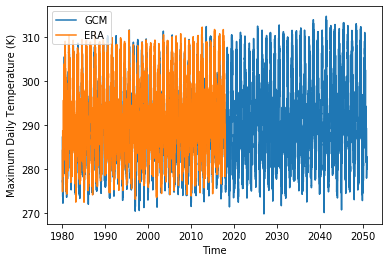

In [9]:
import matplotlib.pyplot as plt 

plt.figure()
plt.plot(df_gcm.index, df_gcm.data, label='GCM')
plt.plot(df_era.index, df_era.data, label='ERA')
plt.xlabel('Time')
plt.ylabel('Maximum Daily Temperature (K)')
plt.legend()
plt.show()

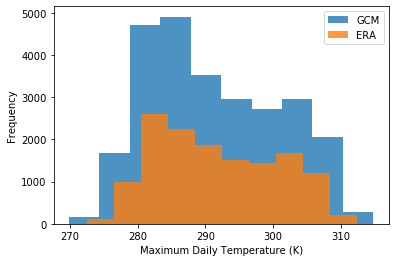

In [10]:
plt.figure()
plt.hist(df_gcm.data, alpha=0.8, label='GCM')
plt.hist(df_era.data, alpha=0.8, label='ERA')
plt.ylabel('Frequency')
plt.xlabel('Maximum Daily Temperature (K)')
plt.legend()
plt.show()

In [73]:
df_era_past = df_era['1980-01-01':'2009-12-31'].copy()
df_gcm_past = df_gcm['1980-01-01':'2009-12-31'].copy()
df_gcm_present = df_gcm['2010-01-01':'2017-12-31'].copy()
df_era_present = df_era['2010-01-01':'2017-12-31'].copy()
df_gcm_future = df_gcm['2020-01-01':'2050-12-31'].copy()

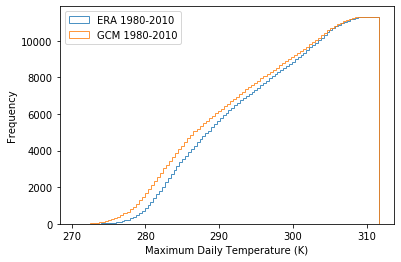

In [21]:
plt.figure()
plt.hist(df_era_past30.data, alpha=0.8, label='ERA 1980-2010', bins=100, cumulative=True, histtype='step')
plt.hist(df_gcm_past30.data, alpha=0.8, label='GCM 1980-2010', bins=100, cumulative=True, histtype='step')
plt.ylabel('Frequency')
plt.xlabel('Maximum Daily Temperature (K)')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  


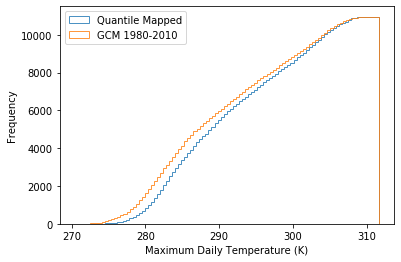

In [78]:
# Create Quantile Mapping
from tqdm import tqdm_notebook as tqdm
quantile_factors = []
for quantile in range(0,101):
    quantile_as_fraction = quantile / 100.0
    quantile_factor = df_era_past.quantile(quantile_as_fraction) / df_gcm_past.quantile(quantile_as_fraction)
    quantile_factors.append(quantile_factor)


def apply_mapping(factors, data_frame):
    quantile_values = []
    for quantile in range(0,101):
        quantile_as_fraction = quantile / 100.0
        quantile_values.append(data_frame.quantile(quantile_as_fraction).data[0])
    
    df_quantile_mapped = data_frame.copy()
    for data_index, datum in enumerate(data_frame.data):
        for i in range(1,101):
            quantile_as_fraction = i / 100.0
            upper_limit = quantile_values[i]
            lower_limit = quantile_values[i-1]
            if datum > lower_limit and datum <= upper_limit:
                df_quantile_mapped.data[data_index] = df_quantile_mapped.data[data_index] * quantile_factors[i]
            
    return df_quantile_mapped

df_gcm_quantile_mapped = apply_mapping(quantile_factors, df_gcm_past)
            
plt.figure()
plt.hist(df_gcm_quantile_mapped.data, alpha=0.8, label='GCM Quantile Mapped 1980-2009', bins=100, cumulative=True, histtype='step')
plt.hist(df_gcm_past.data, alpha=0.8, label='GCM 1980-2009', bins=100, cumulative=True, histtype='step')
plt.ylabel('Frequency')
plt.xlabel('Maximum Daily Temperature (K)')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  


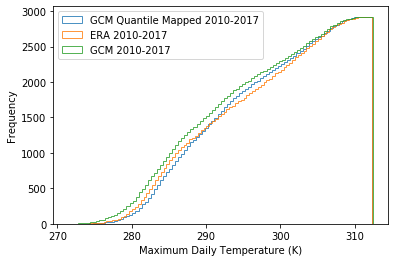

In [79]:
df_gcm_present_quantile_mapped = apply_mapping(quantile_factors, df_gcm_present)

plt.figure()
plt.hist(df_gcm_present_quantile_mapped.data, alpha=0.8, label='GCM Quantile Mapped 2010-2017 using 1980-2009 mapping', bins=100, cumulative=True, histtype='step')
plt.hist(df_era_present.data, alpha=0.8, label='ERA 2010-2017', bins=100, cumulative=True, histtype='step')
plt.hist(df_gcm_present.data, alpha=0.8, label='GCM 2010-2017', bins=100, cumulative=True, histtype='step')
plt.ylabel('Frequency')
plt.xlabel('Maximum Daily Temperature (K)')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  


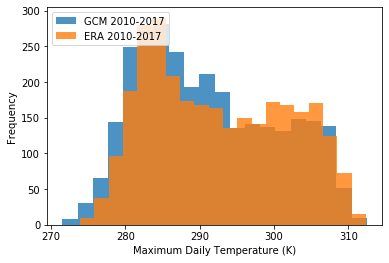

In [87]:
df_gcm_present_quantile_mapped = apply_mapping(quantile_factors, df_gcm_present)

plt.figure()
# plt.hist(df_gcm_present_quantile_mapped.data, alpha=0.8, label='GCM Quantile Mapped 2010-2017 using 1980-2009 mapping', bins=50)
plt.hist(df_gcm_present.data, alpha=0.8, label='GCM 2010-2017', bins=20)
plt.hist(df_era_present.data, alpha=0.8, label='ERA 2010-2017', bins=20)
plt.ylabel('Frequency')
plt.xlabel('Maximum Daily Temperature (K)')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  


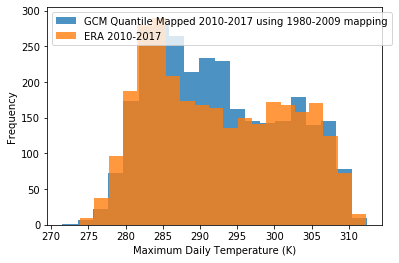

In [86]:
df_gcm_present_quantile_mapped = apply_mapping(quantile_factors, df_gcm_present)

plt.figure()
plt.hist(df_gcm_present_quantile_mapped.data, alpha=0.8, label='GCM Quantile Mapped 2010-2017 using 1980-2009 mapping', bins=20)
plt.hist(df_era_present.data, alpha=0.8, label='ERA 2010-2017', bins=20)
# plt.hist(df_gcm_present.data, alpha=0.8, label='GCM 2010-2017', bins=50)
plt.ylabel('Frequency')
plt.xlabel('Maximum Daily Temperature (K)')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  


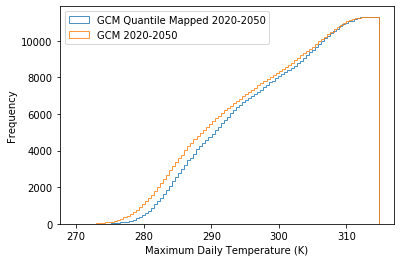

In [80]:
df_gcm_future_quantile_mapped = apply_mapping(quantile_factors, df_gcm_future)

plt.figure()
plt.hist(df_gcm_future_quantile_mapped.data, alpha=0.8, label='GCM Quantile Mapped 2020-2050', bins=100, cumulative=True, histtype='step')
plt.hist(df_gcm_future.data, alpha=0.8, label='GCM 2020-2050', bins=100, cumulative=True, histtype='step')
plt.ylabel('Frequency')
plt.xlabel('Maximum Daily Temperature (K)')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.data is deprecated and will be removed in a future version
  


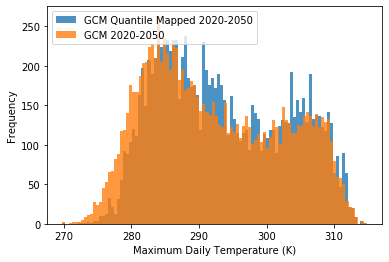

In [89]:
df_gcm_future_quantile_mapped = apply_mapping(quantile_factors, df_gcm_future)

plt.figure()
plt.hist(df_gcm_future_quantile_mapped.data, alpha=0.8, label='GCM Quantile Mapped 2020-2050', bins=100)
plt.hist(df_gcm_future.data, alpha=0.8, label='GCM 2020-2050', bins=100)
plt.ylabel('Frequency')
plt.xlabel('Maximum Daily Temperature (K)')
plt.legend(loc='upper left')
plt.show()

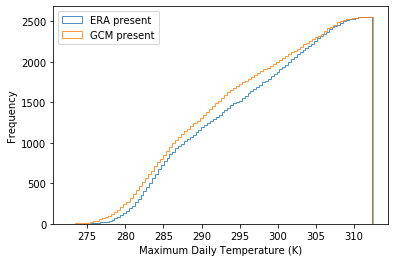

In [24]:
# Present (2011-2017)
plt.figure()
plt.hist(df_era_present.data, alpha=0.8, label='ERA present', bins=100, cumulative=True, histtype='step')
plt.hist(df_gcm_present.data, alpha=0.8, label='GCM present', bins=100, cumulative=True, histtype='step')
plt.ylabel('Frequency')
plt.xlabel('Maximum Daily Temperature (K)')
plt.legend(loc='upper left')
plt.show()